In [283]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from pymc3.math import logsumexp
from scipy.special import logsumexp as sp_logsumexp
from pymc3.distributions.dist_math import rho2sd

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False

env: THEANO_FLAGS=device=cpu,floatX=float32


In [66]:
train_path = "kurohime_bike.jpeg"

In [67]:
img = plt.imread(train_path)

In [68]:
img.shape

(540, 960, 3)

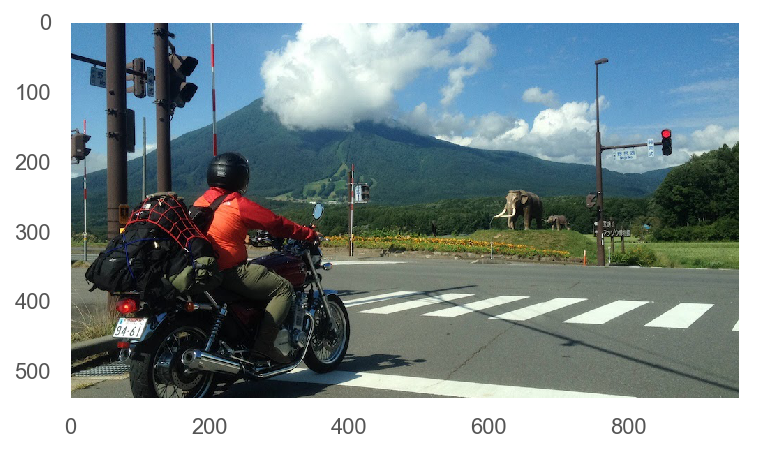

In [284]:
plt.imshow(img)

In [70]:
X = img.reshape(-1, 3).astype(int)
N, D = X.shape
print(N, D)

518400 3


In [71]:
type(X)

numpy.ndarray

# Model

$p(x_n | \pi, \mu, \sigma) = \sum_{i=1}^K \pi_k \text{Normal}(x_n | \mu_k, \Sigma_k)$

$p(\pi) = \text{Dirichlet} (\pi | \alpha \mathbf{1}_k)$

$p(\mu_k) = \text{Normal}(0,I)$

$p(\Sigma_k ) = \text{LKJ} (\Sigma | \eta,sd) $

In [141]:
X_shared = theano.shared(X)

minibatch_size = 500
X_minibatch = pm.Minibatch(X, minibatch_size)

In [209]:
# set up model
K = 20
with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K))

    comp_dist = []
    mu = []
    packed_chol = []
    chol = []
    for i in range(K):
        temp_mean = np.random.randint(low=50, high=200, size=3)
        #print(temp_mean)
        mu.append(pm.Normal('mu%i'%i, temp_mean, 20, shape=3))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i,
                                             eta=2, 
                                             n=3, 
                                             sd_dist=pm.HalfNormal.dist(10)))
        chol.append(pm.expand_packed_triangular(3, packed_chol[i], lower=True))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], chol=chol[i]))

    xobs = pm.Mixture('x_obs', pi, comp_dist,
            observed=X_shared)


# Inference

In [210]:
with model:
    advi_mf=pm.ADVI()
    advi_mf.fit(5000, more_replacements={X_shared: X_minibatch},
                obj_optimizer=pm.adagrad(learning_rate=1e-2))

Average Loss = 1.9588e+05: 100%|██████████| 5000/5000 [01:12<00:00, 58.65it/s]
Finished [100%]: Average Loss = 1.9563e+05


In [211]:
advi_mf.refine(5000)

Average Loss = 1.3228e+05: 100%|██████████| 5000/5000 [01:03<00:00, 74.02it/s]
Finished [100%]: Average Loss = 1.3218e+05


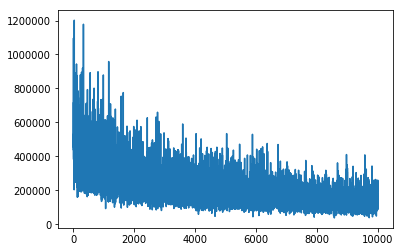

In [212]:
plt.plot(advi_mf.hist);

In [213]:
def predict_cluster(approx, nsample, X):
    complogp = xobs.distribution._comp_logp(theano.shared(X))
    f_complogp = model.model.fastfn(complogp)
    trace = approx.sample(nsample)
    
    point = model.test_point
    for i in np.arange(K):
        point['mu%i'%i] = np.mean(trace['mu%i'%i], axis=0) # take average over samples
        chollabel = 'chol_cov_%i_cholesky-cov-packed__'%i
        point[chollabel] = np.mean(trace[chollabel], axis=0) # take average over samples
        
    y = np.argmax(f_complogp(point), axis=1)
    return y, point

In [214]:
y, point = predict_cluster(advi_mf.approx, 1000, X)

In [215]:
nrows, ncols = img.shape[0], img.shape[1]
segmented_img = np.zeros((nrows, ncols, D),dtype='int')

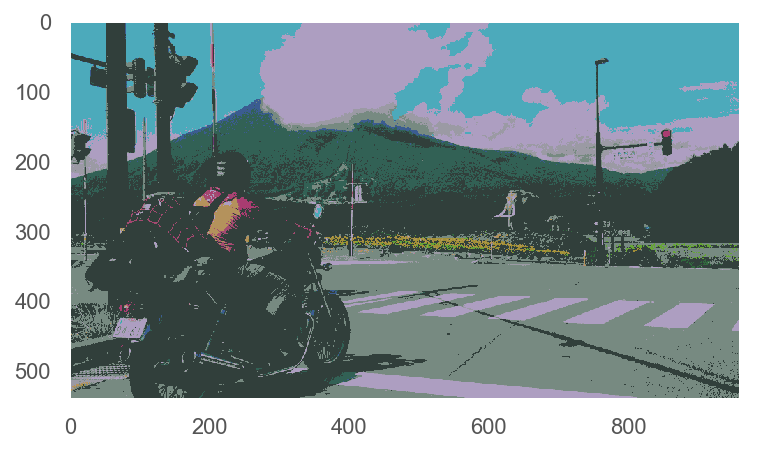

In [285]:
cluster_reshape = y.reshape(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        cluster_number = cluster_reshape[i, j]
        segmented_img[i, j] = point['mu{0:d}'.format(cluster_number)].astype(int)
plt.imshow(segmented_img)

In [238]:
post_samples = advi_mf.approx.sample(100)

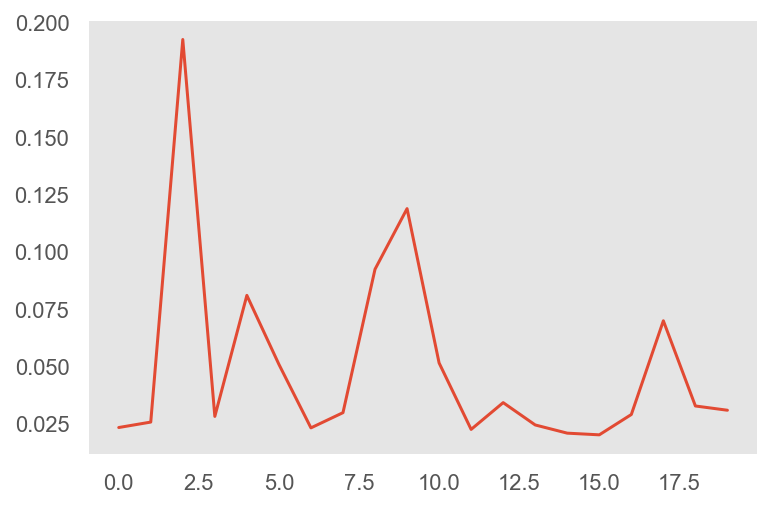

In [287]:
plt.plot(np.arange(0,20), post_samples['pi'].mean(axis=0))

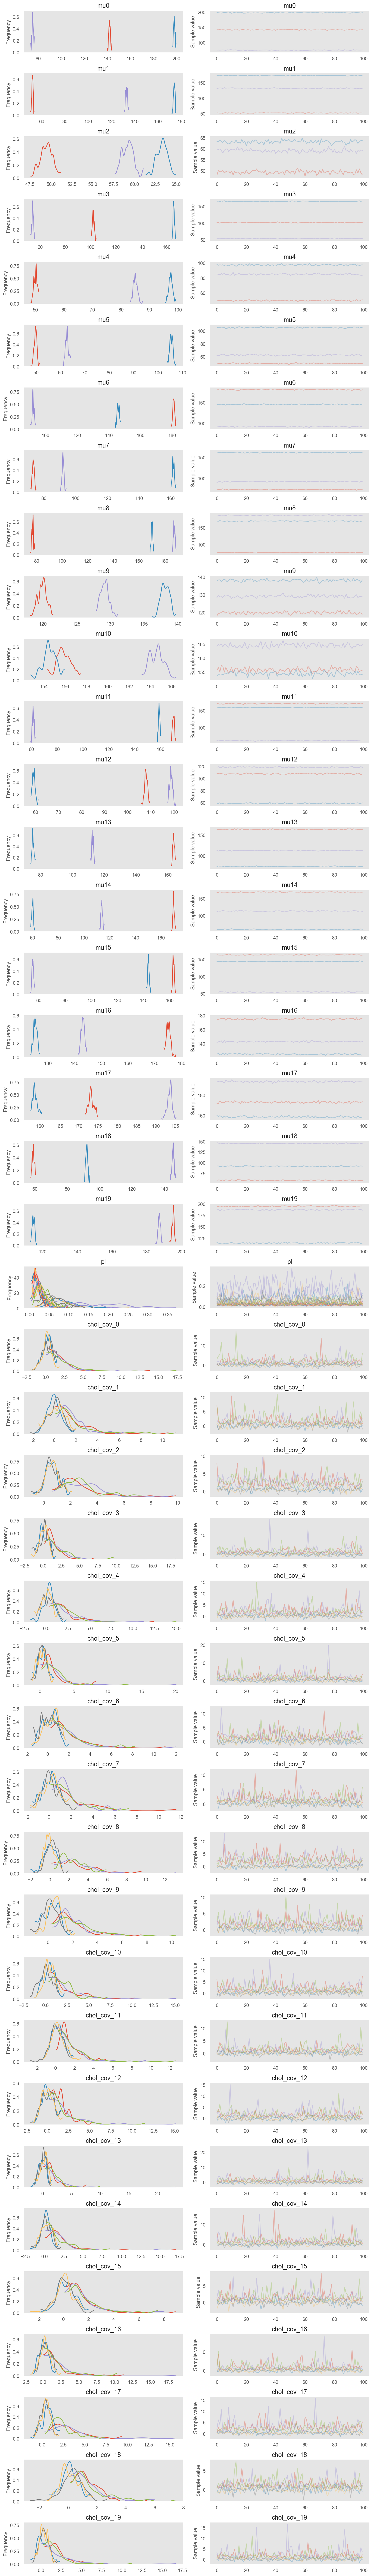

In [286]:
pm.traceplot(post_samples);

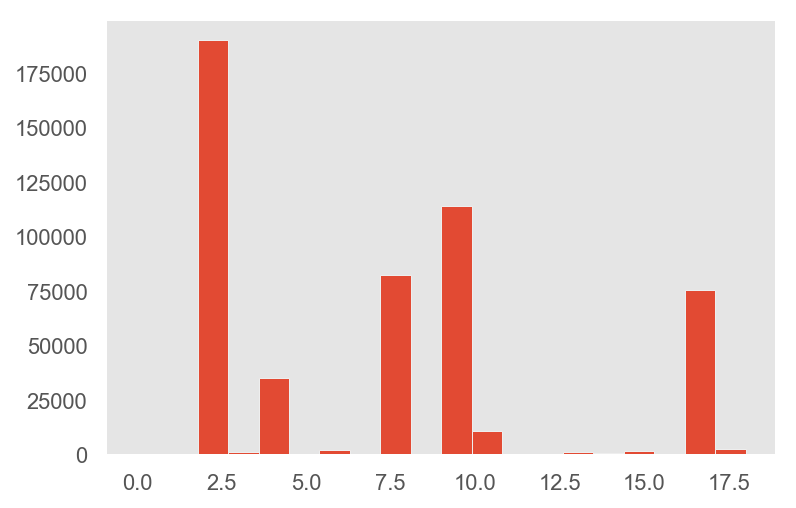

In [288]:
plt.hist(y, bins=20);

# Diagnosis

In [228]:
from utils import PDI

In [230]:
from pymc3.stats import _log_post_trace
from pymc3.distributions.dist_math import rho2sd

from scipy.special import logsumexp as sp_logsumexp
import scipy.stats as st

In [239]:
def PDI_local(trace, model):
    print("hi")
    log_px = _log_post_trace(trace, model)  # shape (nsamples, N_datapoints)

    print("finish first part")

    # log posterior predictive density of data point n = E_{q(\theta)} p(x_n|\theta)
    lppd_n = sp_logsumexp(log_px, axis=0, b=1.0 / log_px.shape[0])

    mu_n = np.exp(lppd_n)

    var_log_n = np.var(log_px, axis=0)

    mu_log_n = np.mean(log_px, axis=0)

    var_n = np.var(np.exp(log_px), axis=0)

    pdi = np.divide(var_n, mu_n)
    pdi_log = np.divide(var_log_n, mu_log_n)

    wapdi = np.divide(var_log_n, np.log(mu_n))

    return pdi, pdi_log, wapdi

In [240]:
pdi, pdi_log, wapdi = PDI_local(post_samples, model) # average over 100 samples

hi
finish first part


In [275]:
pdi_reshape = pdi.reshape(nrows, ncols)
pdi_log_reshape = pdi_log.reshape(nrows, ncols)
wapdi_reshape = wapdi.reshape(nrows, ncols)

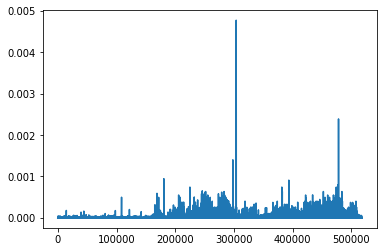

In [262]:
plt.plot(pdi)

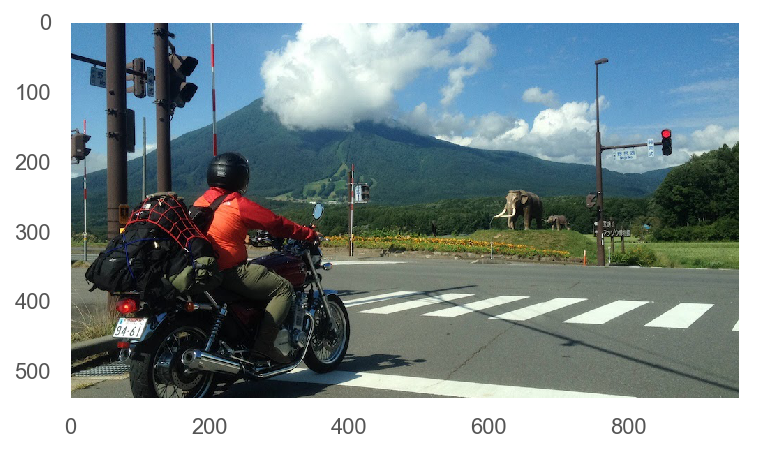

In [289]:
plt.imshow(img)

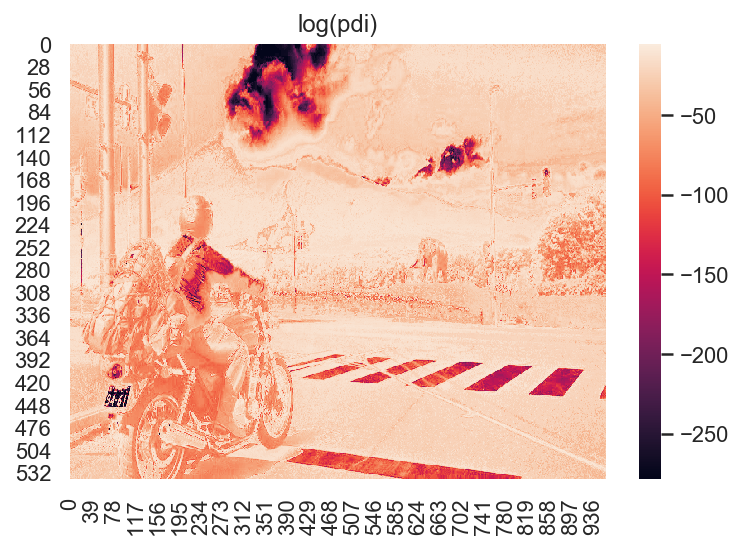

In [297]:
sns.set()
ax = sns.heatmap(np.log(pdi_reshape))
ax.set_title("log(pdi)");

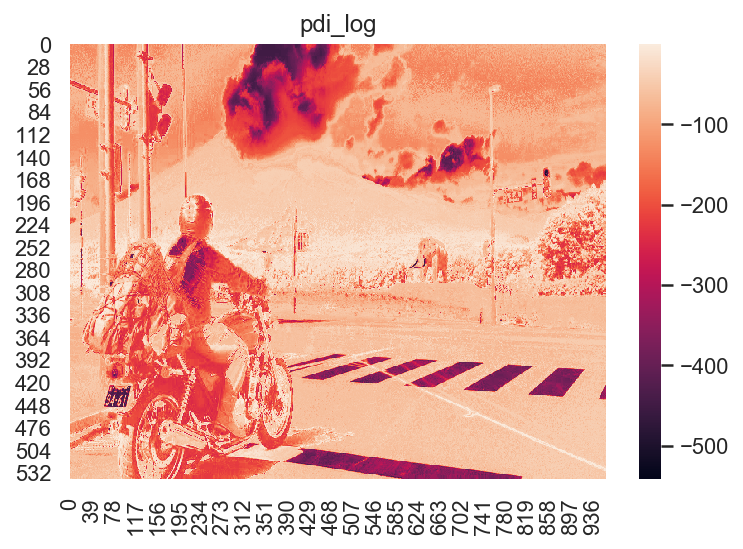

In [298]:
sns.set()
ax = sns.heatmap(pdi_log_reshape)
ax.set_title("pdi_log");

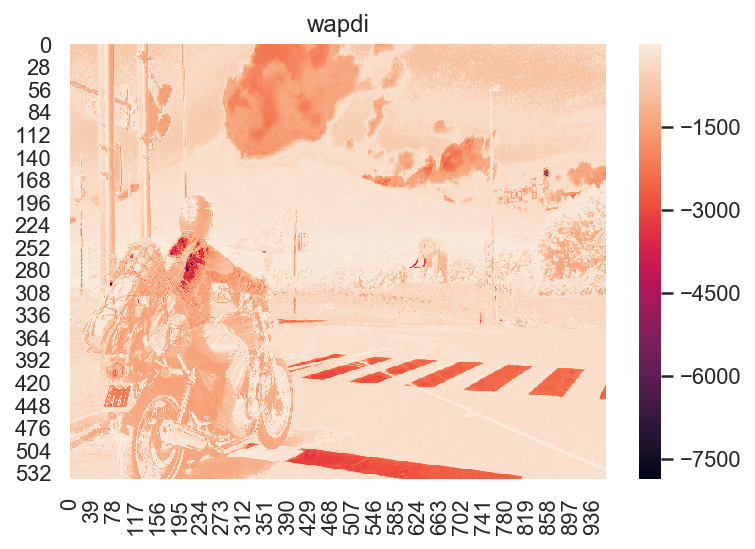

In [299]:
sns.set()
ax = sns.heatmap(wapdi_reshape)
ax.set_title("wapdi");

In [264]:
# conclusion
#setting priors for mu
# as alpha goes down, more concentrated

# Try full rank

In [58]:
# set up model
K = 12
with pm.Model() as model:
    pi = pm.Dirichlet('pi', np.ones(K)*0.01)

    comp_dist = []
    mu = []
    packed_chol = []
    chol = []
    for i in range(K):
        temp_mean = np.random.randint(low=50, high=200, size=3)
        print(temp_mean)
        mu.append(pm.Normal('mu%i'%i, temp_mean, 20, shape=3))
        packed_chol.append(pm.LKJCholeskyCov('chol_cov_%i'%i,
                                             eta=1, 
                                             n=3, 
                                             sd_dist=pm.HalfNormal.dist(10)))
        chol.append(pm.expand_packed_triangular(3, packed_chol[i], lower=True))
        comp_dist.append(pm.MvNormal.dist(mu=mu[i], chol=chol[i]))

    xobs = pm.Mixture('x_obs', pi, comp_dist,
            observed=X_shared)


[180  99  97]
[ 96  87 169]
[183 190 129]
[ 69 117 170]
[127 189 194]
[152 182 173]
[152 176 126]
[175 156 134]
[124 114 102]
[103  84 174]
[125 104 105]
[ 87 138  63]


In [59]:
with model:
    advi_fr=pm.FullRankADVI()
    advi_fr.fit(50000, more_replacements={X_shared: X_minibatch},
                obj_optimizer=pm.adagrad(learning_rate=1e-4))

Average Loss = 1.0759e+06: 100%|██████████| 50000/50000 [08:31<00:00, 97.84it/s] 
Finished [100%]: Average Loss = 1.0751e+06


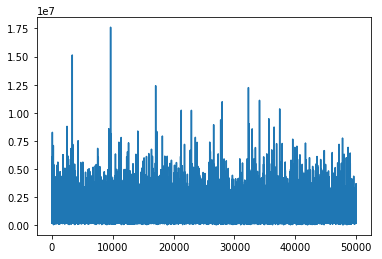

In [60]:
plt.plot(advi_fr.hist)

In [61]:
advi_fr.refine(30000)

Average Loss = 1.2948e+06:   0%|          | 133/30000 [00:01<05:59, 83.14it/s]
Interrupted at 133 [0%]: Average Loss = 1.2979e+06


In [62]:
y_2, point_2 = predict_cluster(advi_fr.approx, 1000, X)

(array([9.2000e+01, 4.0000e+00, 5.5848e+04, 3.0785e+04, 2.3930e+03,
        5.8000e+01, 9.9000e+01, 3.9810e+03, 0.0000e+00, 6.1141e+04]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

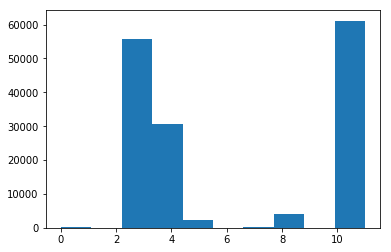

In [63]:
plt.hist(y_2)

In [64]:
nrows, ncols = img.shape[0], img.shape[1]
segmented_img = np.zeros((nrows, ncols, D),dtype='int')

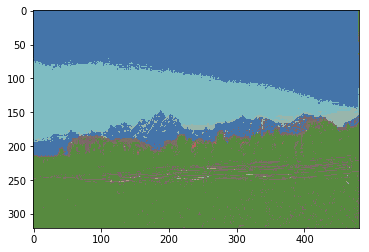

In [65]:
cluster_reshape = y_2.reshape(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        cluster_number = cluster_reshape[i, j]
        segmented_img[i, j] = point_2['mu{0:d}'.format(cluster_number)].astype(int)
plt.imshow(segmented_img)

In [ ]:
post_samples_2 = advi_fr.approx.sample(100)

In [ ]:
pm.traceplot(post_samples_2);

In [290]:
train_path_test = "/Users/leah/Columbia/courses/ml_prob_programming/ENV/BSR/BSDS500/data/images/train/"

In [292]:
img_test = plt.imread(train_path_test+ "25098.jpg")

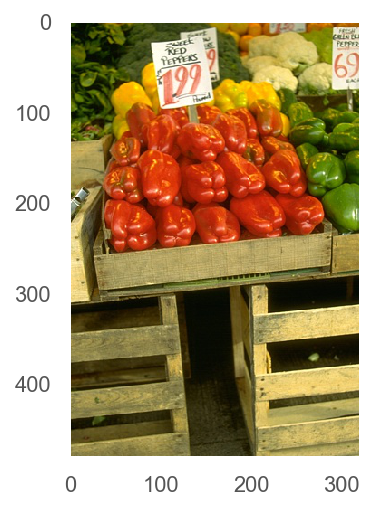

In [293]:
plt.imshow(img_test)

In [295]:
img_test.shape[0] * img_test.shape[1]

154401

In [ ]:
# when k increases, we need to lower alpha

In [300]:
%time print("hi")

hi
CPU times: user 227 µs, sys: 107 µs, total: 334 µs
Wall time: 249 µs
